In [1]:
####################################################################
# 1. Libraries

import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

import tensorflow as tf
tf.keras.backend.clear_session()

physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers
from tensorflow.keras.utils import Sequence

import xgboost as xgb
import lightgbm as lgbm

import pickle

####################################################################

In [2]:
####################################################################
# 2. Global Variables

path_input = '../03_Datasets/Dataset_v0_7/'
name_dataset = 'dataset.csv'

####################################################################

In [3]:
####################################################################
# 3. Load Data

pc_keep_duplicates = 0.5

dataset = pd.read_csv(path_input + name_dataset)
dataset = dataset.fillna(0)
dataset = dataset[dataset['list_count']>=1].reset_index(drop=True)

list_columns_f = [col for col in dataset.columns if col not in ['step', 'list_id_bandit']]
dataset['in_duplicated'] = np.where(dataset[list_columns_f].duplicated(keep=False), 1, 0)

size_duplis = dataset['in_duplicated'].shape[0]
list_experiments = list(dataset['experiment'].unique())

dataset_final = pd.DataFrame()
for experiment in tqdm(list_experiments):
    df_tmp = dataset[dataset['experiment']==experiment]
    shape_dups = int(df_tmp[df_tmp['in_duplicated']==1].shape[0]*pc_keep_duplicates)
    df_experiment = pd.concat([df_tmp[df_tmp['in_duplicated']==0], df_tmp[df_tmp['in_duplicated']==1].sample(shape_dups)], axis=0)
    dataset_final = pd.concat([dataset_final, df_experiment], axis=0)

dataset_final = dataset_final.fillna(0)
dataset_final['sample_weight'] = 1
dataset_final['sample_weight'][(dataset_final['list_count_me']>=3) & (dataset_final['list_count_me']<=12)] = 2
dataset_final['sample_weight'][dataset_final['list_count_me']>12] = 3
dataset_final = dataset_final.reset_index(drop=True)

# print(dataset.shape, dataset_final.shape, dataset_max_prob_step.shape)

print(dataset.shape, dataset_final.shape)

####################################################################

C:\Users\Enric\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Enric\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6653229, 19) (3354378, 20)


In [4]:
####################################################################
# 4. Data Generator

class DataGenerator(Sequence):
    
    def __init__(self, dataset, batch_size, shuffle=True, training=True):
        super(DataGenerator, self).__init__()
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.training = training
        self.shuffle = shuffle
        self.on_epoch_end()
        self.list_target_columns = ['list_prob']
        self.list_features = [col for col in self.dataset.columns if col not in self.list_target_columns and col not in ['in_duplicated', 'step', 'experiment', 'list_id_bandit', 'sample_weight']]
        
    def __len__(self):
        self.num_steps = int(np.ceil(self.dataset.shape[0] / self.batch_size))
        return self.num_steps
        
    def __getitem__(self, idx):
        indexes = np.asarray(self.indexes[idx*self.batch_size:(idx+1)*self.batch_size])
        
        batch_data = self.dataset[self.list_features].loc[indexes].values
        batch_labels = self.dataset[self.list_target_columns].loc[indexes].values

        if self.training:
            batch_sample_weights = self.dataset['sample_weight'].loc[indexes].values
            return batch_data, batch_labels#, batch_sample_weights
        else:
            return batch_data
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.dataset.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
            
# Custom Loss

def quantileLoss(y_true, y_pred):
    quantiles = tf.constant([0.3, 0.5, 0.7])
    e = y_true - y_pred
    v = tf.maximum(quantiles * e, (quantiles-1) * e)
    return tf.reduce_mean(v)

            
####################################################################

In [5]:
####################################################################
# 5. Model
    
def buildmodel(summary=False):
    
    in_ = layers.Input((14,))
    x = layers.BatchNormalization()(in_)
    x = layers.Dense(32, activation='relu')(in_)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    y1 = layers.Dense(1, activation='sigmoid', name='reg')(x)
    
    model = models.Model(inputs=[in_], outputs=[y1])

    model.compile(optimizer=optimizers.Adam(learning_rate=8e-4), 
                  loss=[losses.Huber()],
                  metrics=[metrics.MeanAbsoluteError(name='mae: '),
                           metrics.MeanSquaredError(name='mse: ')])
    if summary:
        print(model.summary())
    
    return model



def buildBoostingModel(X_train, y_train, X_val, y_val, weights_train, weights_val):

    params = {
        'max_depth': 5,
        'min_child_weight':0.0,
        'subsample':0.9,
        'alpha' : 1.0, 
        'gamma' : 1.0,
        'colsample_bytree': 0.9,
        'obj': 'reg:squarederror',
        'n_estimators': 200,
        'learning_rate': 0.08
    }
    
    train_dmatrix = xgb.DMatrix(X_train, y_train, weight=weights_train)
    val_dmatrix = xgb.DMatrix(X_val, y_val, weight=weights_val)
    watchlist = [(train_dmatrix, 'train'), (val_dmatrix, 'valid')]
    
    model = xgb.train(params, train_dmatrix, evals=watchlist,
                      num_boost_round=500, 
                      verbose_eval=10, early_stopping_rounds=20)
    
    return model
    
    
####################################################################

In [6]:
####################################################################
# 6. Training

arch_name = 'base_v0_14'
batch_size = 1024
save = True
validation_size = 0.1
train_nn = False
train_xgb = True

idxs_validation = np.arange(dataset_final.shape[0])
np.random.shuffle(idxs_validation)
idxs_train = idxs_validation[:int(dataset_final.shape[0]*(1-validation_size))]
idxs_val = idxs_validation[int(dataset_final.shape[0]*(1-validation_size)):]

dataset_train = dataset_final.loc[idxs_train].reset_index(drop=True)
dataset_val = dataset_final.loc[idxs_val].reset_index(drop=True)

X_train_generator = DataGenerator(dataset_train, batch_size, shuffle=True, training=True)
X_val_generator = DataGenerator(dataset_val, batch_size, shuffle=True, training=True)

if train_nn:
    model = buildmodel(summary=True)

    history = model.fit(X_train_generator,
                        validation_data=X_val_generator,
                        batch_size=batch_size,
                        epochs=10,
                        verbose=1)

    if save:
        model.save(f'../04_Models/{arch_name}/model_{arch_name}')
        model.save(f'../04_Models/{arch_name}/model_{arch_name}.h5')
    
    print('***'*20)
    
if train_xgb:
    model_name = 'model_xgb_v07'
    list_target_columns = ['list_prob']
    list_features = [col for col in dataset_train.columns if col not in list_target_columns and col not in ['in_duplicated', 'step', 'experiment', 'list_id_bandit', 'sample_weight']]
    X_train, y_train = dataset_train[list_features], dataset_train[list_target_columns]
    X_val, y_val = dataset_val[list_features], dataset_val[list_target_columns]

    xgb_model = buildBoostingModel(X_train, y_train, X_val, y_val,
                                   weights_train=dataset_train['sample_weight'],
                                   weights_val=dataset_val['sample_weight'])
    
    if save:
        pickle.dump(xgb_model, open(f'../04_Models/{model_name}.pickle', 'wb')) 
    print('***'*20)

####################################################################

[14:19:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators, obj } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.28218	valid-rmse:0.28240
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:0.15190	valid-rmse:0.15211
[20]	train-rmse:0.11036	valid-rmse:0.11053
[30]	train-rmse:0.10011	valid-rmse:0.10024
[40]	train-rmse:0.09777	valid-rmse:0.09787
[50]	train-rmse:0.09706	valid-rmse:0.09716
[60]	train-rmse:0.09679	valid-rmse:0.09688
[70]	train-rmse:0.09658	valid-rmse:0.09667
[80]	train-rmse:0.09648	valid-rmse:0.09657
[90]	train-rmse:0.09639	valid-rmse:0.09648
[100]	train-rmse:0.09629	valid-

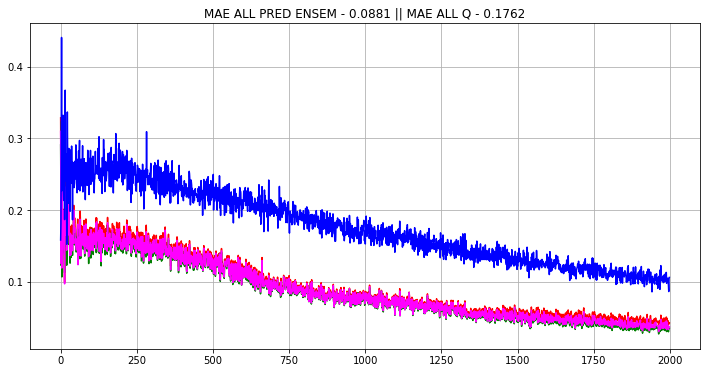

MAE Predictions NN: 0.08840021341490095
MAE Predictions XGB: 0.08205827324618441
MAE Predictions ENSEM: 0.08426171414741002
MAE Q-Wins: 0.17223495798946478
************************************************************


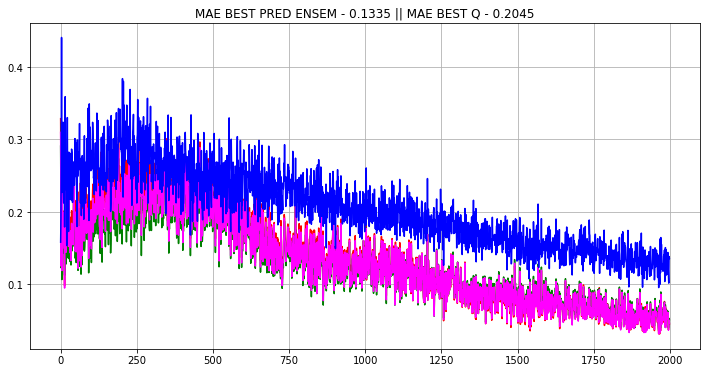

MAE Predictions NN: 0.13887169853791898
MAE Predictions XGB: 0.12991987236854938
MAE Predictions ENSEM: 0.13348697794744396
MAE Q-Wins: 0.20449985133714396
************************************************************


In [7]:
####################################################################
# 7. Test

# 0.1415

arch_name = 'base_v0_14'
arch_xgb = 'model_xgb_v07'
model = models.load_model(f'../04_Models/{arch_name}/model_{arch_name}')
xgb_model = pickle.load(open(f'../04_Models/{arch_xgb}.pickle', 'rb')) 
list_target_columns = ['list_prob']
list_features = [col for col in dataset_train.columns if col not in list_target_columns and col not in ['in_duplicated', 'step', 'experiment', 'list_id_bandit', 'sample_weight']]

X_test_generator = DataGenerator(dataset_val, batch_size, shuffle=False, training=False)
predictions = model.predict(X_test_generator)
df_test = dataset_val.copy()

df_test['list_prob_pred_nn'] = predictions
df_test['list_prob_pred_xgb'] = xgb_model.predict(xgb.DMatrix(dataset_val[list_features]))
df_test['list_prob_pred_ensem'] = 0.5*df_test['list_prob_pred_nn'] + 0.5*df_test['list_prob_pred_xgb']
    
df_test['mae_pred_nn'] = np.abs(df_test[f'list_prob'] - df_test[f'list_prob_pred_nn'])
df_test['mae_pred_xgb'] = np.abs(df_test[f'list_prob'] - df_test[f'list_prob_pred_xgb'])
df_test['mae_pred_ensem'] = np.abs(df_test[f'list_prob'] - df_test[f'list_prob_pred_ensem'])
df_test['mae_q'] = np.abs(df_test[f'list_prob'] - df_test[f'list_qwins'])

list_columns_mae = ['mae_pred_nn', 'mae_pred_xgb', 'mae_pred_ensem', 'mae_q']

df_evolution = df_test.groupby('step')[list_columns_mae].mean()
df_evolution['step'] = df_evolution.index
df_evolution = df_evolution.reset_index(drop=True)
list_mae_nn, list_mae_xgb = df_evolution['mae_pred_nn'].values,  df_evolution['mae_pred_xgb'].values
list_mae_ensem, list_mae_q = df_evolution['mae_pred_ensem'].values,  df_evolution['mae_q'].values
    
plt.figure(figsize=(12, 6))
plt.title(f'MAE ALL PRED ENSEM - {np.round(np.mean(list_mae_ensem), 4)} || MAE ALL Q - {np.round(np.mean(list_mae_q), 4)}')
plt.plot(list_mae_nn, 'red')
plt.plot(list_mae_xgb, 'green')
plt.plot(list_mae_ensem, 'magenta')
plt.plot(list_mae_q, 'blue')
plt.grid()
plt.show()

print(f"MAE Predictions NN: {np.mean(df_test['mae_pred_nn'])}")
print(f"MAE Predictions XGB: {np.mean(df_test['mae_pred_xgb'])}")
print(f"MAE Predictions ENSEM: {np.mean(df_test['mae_pred_ensem'])}")
print(f"MAE Q-Wins: {np.mean(df_test['mae_q'])}")
print('***'*20)

## For best prob for each Exp/step

df_max_prob_step = df_test.groupby(['experiment', 'step'])['list_prob'].max().reset_index()
df_max_prob = df_test.merge(df_max_prob_step, how='inner', on=['experiment', 'step', 'list_prob'])
df_max_prob = df_max_prob.groupby('step')[list_columns_mae].mean()
df_max_prob['step'] = df_max_prob.index
df_max_prob = df_max_prob.reset_index(drop=True)

list_mae_nn, list_mae_xgb = df_max_prob['mae_pred_nn'].values,  df_max_prob['mae_pred_xgb'].values
list_mae_ensem, list_mae_q = df_max_prob['mae_pred_ensem'].values,  df_max_prob['mae_q'].values

plt.figure(figsize=(12, 6))
plt.title(f'MAE BEST PRED ENSEM - {np.round(np.mean(list_mae_ensem), 4)} || MAE BEST Q - {np.round(np.mean(list_mae_q), 4)}')
plt.plot(list_mae_nn, 'red')
plt.plot(list_mae_xgb, 'green')
plt.plot(list_mae_ensem, 'magenta')
plt.plot(list_mae_q, 'blue')
plt.grid()
plt.show()

print(f"MAE Predictions NN: {np.mean(df_max_prob['mae_pred_nn'])}")
print(f"MAE Predictions XGB: {np.mean(df_max_prob['mae_pred_xgb'])}")
print(f"MAE Predictions ENSEM: {np.mean(df_max_prob['mae_pred_ensem'])}")
print(f"MAE Q-Wins: {np.mean(df_max_prob['mae_q'])}")
print('***'*20)


####################################################################

In [8]:
list_columns_predictions = ['list_prob', 'list_prob_pred_nn', 'list_prob_pred_xgb', 'list_prob_pred_ensem']
df_test[list_columns_predictions].describe()

,list_prob,list_prob_pred_nn,list_prob_pred_xgb,list_prob_pred_ensem
count,335438.000000,335438.000000,335438.000000,335438.000000
mean,0.244800,0.243762,0.245233,0.244535
std,0.163325,0.084810,0.104077,0.093856
min,0.000199,0.000313,0.025009,0.019069
25%,0.131894,0.184276,0.161687,0.172613
50%,0.202258,0.223272,0.222309,0.222791
75%,0.319930,0.300199,0.306416,0.303308
max,0.956195,0.589193,0.744314,0.662311


In [9]:
####################################################
# Explainability

import shap

shap.initjs()

explainer = shap.DeepExplainer(model, data=X_train.values)
shap_values = explainer.shap_values(X_train.loc[:1_000].values)

shap.summary_plot(shap_values, X_train)

####################################################

You have provided over 5k background samples! For better performance consider using smaller random sample.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


ResourceExhaustedError:  OOM when allocating tensor with shape[6037880,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/dense/Relu (defined at C:\Users\Enric\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:240) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_grad_graph_1677]

Function call stack:
grad_graph


In [ ]:
idx = 500
print(X_train.iloc[idx,:], y_train.iloc[idx, :])
shap.force_plot(explainer.expected_value.numpy(), shap_values[0][idx,:], X_train.iloc[idx,:])

In [ ]:
idx = 1000
print(X_train.iloc[idx,:], y_train.iloc[idx, :])
shap.force_plot(explainer.expected_value.numpy(), shap_values[0][idx,:], X_train.iloc[idx,:])

In [ ]:
####################################################
# Explainability

import shap

shap.initjs()

list_target_columns = ['list_prob']
list_features = [col for col in dataset_val.columns if col not in list_target_columns and col not in ['in_duplicated', 'step', 'experiment', 'list_id_bandit', 'sample_weight']]

X_val, y_val = dataset_val[list_features], dataset_val[list_target_columns]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val.values)

shap.summary_plot(shap_values, X_val, plot_type="bar")

####################################################

In [ ]:
idx = 500
print(X_val.iloc[idx,:], y_val.iloc[idx, :])
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_val.iloc[idx,:])

In [ ]:
idx = 5_000
print(X_val.iloc[idx,:], y_val.iloc[idx, :])
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_val.iloc[idx,:])

In [ ]:
idx = int(y_val.values.argmax())
print(X_val.iloc[idx,:], y_val.iloc[idx, :])
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_val.iloc[idx,:])